In [1]:
import pandas as pd
import os
from scipy.stats import norm
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import sys
sys.path.insert(0,'../src/data')
sys.path.insert(0,'../src/modules')
import load_pose_data
import skvideo.io
import itertools
from sklearn.metrics import roc_auc_score, roc_curve

def plot_skel(df, vid, frame,ax,xvar,yvar):
    alpha =.7
    df = df[(df.frame==frame)].reset_index(drop=True)
    for i,limb in enumerate(limbSeq):
        l1 = limb[0]-1; l2 = limb[1]-1;
        if (len(df[df.part_idx==l1])>0) & (len(df[df.part_idx==l2])>0):
            ax.plot([df[df.part_idx==l1][xvar].iloc[0],df[df.part_idx==l2][xvar].iloc[0]], [df[df.part_idx==l1][yvar].iloc[0],df[df.part_idx==l2][yvar].iloc[0]],linewidth=5, color=[j/255 for j in colors[i]], alpha=alpha)
    # plot kp
    for i in range(len(df)):
        ax.plot(df[xvar][i],df[yvar][i], 'o',markersize = 10, color=[j/255 for j in colors[i]], alpha=alpha)

def gen_one_frame(df, vid, frame,dpi):
    fig=plt.figure(dpi=dpi)
    canvas = FigureCanvas(fig)
    ax = plt.gca()
    
    plot_skel(df, vid, i, ax, 'x', 'y')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2)
    ax.invert_yaxis()
    ax.axis('off')
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    im = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
    im = im.reshape(int(height), int(width), 3)
    plt.close()
    return im

def get_one_frame(video,f1):
    videogen = skvideo.io.vreader(video)
    new_videogen = itertools.islice(videogen, f1, f1+1, 1)
    for image in new_videogen:
        a = 1
    return image

colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0],
          [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255],
          [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85],[255, 0, 0]]

limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
           [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
           [1, 16], [16, 18], [3, 17], [6, 18]]

fontsize=15

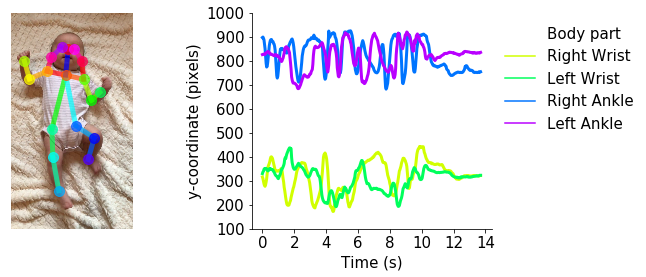

In [2]:
data_set = 'example_video'
path = '../data/example_video'
pose_path = '../data/pose_estimates/example_video/py/pose_estimates.pkl'

load_pose_data.main(data_set, path)

df = pd.read_pickle(pose_path)
vid = 'video_exampl'
vidpath = os.path.join(path,vid+'.mov')
frame1 = 55
framen = 56
frame_interval = 1
xvar = 'x'
yvar = 'y'

fig,axs=plt.subplots(nrows=1,ncols=2, figsize=(10,5))
ax = axs[0]
img = get_one_frame(vidpath,framen)
ax.imshow(img)
for i in np.arange(frame1,framen,frame_interval):
    plot_skel(df[df.frame==i], vid, i, ax, xvar,yvar)
ax.set_aspect('equal', adjustable='box')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = axs[1]
df = df[np.isin(df.bp, ['LAnkle', 'RAnkle', 'LWrist', 'RWrist'])]
df.loc[df.bp=='LAnkle','bp'] = 'Left Ankle'
df.loc[df.bp=='RAnkle','bp'] = 'Right Ankle'
df.loc[df.bp=='LWrist','bp'] = 'Left Wrist'
df.loc[df.bp=='RWrist','bp'] = 'Right Wrist'
df['Body part'] = df['bp']
df['time'] = df['frame']/30
sns.lineplot(x='time', y='y', hue='Body part', data=df, ax = ax, palette="hsv", linewidth=3)
ax.set_xlabel('Time (s)',fontsize=fontsize)
ax.set_ylabel('y-coordinate (pixels)',fontsize=fontsize)
ax.set_yticks(np.arange(100,1100, step=100))
ax.set_yticklabels(np.arange(100,1100, step=100),fontsize=fontsize)
ax.set_xticks(np.arange(0,16, step=2))
ax.set_xticklabels(np.arange(0,16, step=2),fontsize=fontsize)
ax.legend(bbox_to_anchor=(1,1), frameon=False,fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# sns.despine()
fig.subplots_adjust(left=.05, bottom=.2, right=.8, top=.8, wspace=.25, hspace=.2)
fig.savefig('../data/visualization/pose_estimates.pdf') 

In [3]:
path = '../data/processed/'

surprise = pd.read_pickle(os.path.join(path, 'bayes_surprise.pkl'))
features = pd.read_pickle(os.path.join(path, 'final_feature_set.pkl'))

# We will include the following features computed from the positions of the extremities (wrists/ankles) and joint angles (elbows/knees):
# - absolute position/angle
# - variability of position/angle
# - median speed
# - variability of speed
# - median absolute velocity
# - variability of velocity
# - variability of acceleration
# - measure of complexity (entropy)
# - measure of symmetry (left-right cross correlation)

# 'Elbow_stdev_angle'
feature_list = ['Wrist_mediandist','Ankle_mediandist','Elbow_mean_angle', 'Knee_mean_angle',\
                'Wrist_IQRdist','Ankle_IQRdist','Elbow_stdev_angle', 'Knee_stdev_angle',\
                'Wrist_medianspeed','Ankle_medianspeed',\
                'Wrist_IQRspeed','Ankle_IQRspeed',\
                'Wrist_medianvel','Ankle_medianvel','Elbow_median_vel_angle','Knee_median_vel_angle',\
                'Wrist_IQRvel','Ankle_IQRvel', 'Elbow_IQR_vel_angle', 'Knee_IQR_vel_angle',\
                'Wrist_IQRacc', 'Ankle_IQRacc', 'Elbow_IQR_acc_angle','Knee_IQR_acc_angle',\
                'Wrist_meanent', 'Ankle_meanent', 'Elbow_entropy_angle', 'Knee_entropy_angle',\
                'Wrist_lrCorr_x','Ankle_lrCorr_x', 'Elbow_lrCorr_angle', 'Knee_lrCorr_angle']
                
labels_list = ['Median wrist position','Median ankle position','Mean elbow angle','Mean knee angle',\
'IQR wrist position', 'IQR ankle position', 'Stdev. elbow angle','Stdev. knee angle',\
'Median wrist speed','Median ankle speed', 'IQR wrist speed','IQR ankle speed',\
'Median wrist velocity','Median ankle velocity' ,'Median elbow angular velocity', 'Median knee angular velocity',\
'IQR wrist velocity','IQR ankle velocity','IQR elbow angular velocity','IQR knee angular velocity',\
'IQR wrist acceleration','IQR ankle acceleration','IQR elbow angular acceleration','IQR knee angular acceleration',\
'Entropy wrist position', 'Entropy ankle position','Entropy elbow angle', 'Entropy knee angle',\
'Cross-correlation wrist position', 'Cross-correlation ankle position','Cross-correlation elbow angle','Cross-correlation knee angle']

labels_list_feature = ['Median position (l)','Median position (l)','Mean angle (deg.)','Mean angle (deg.)',\
'IQR position (l)', 'IQR position (l)', 'Stdev. angle (deg.)','Stdev. angle (deg.)',\
'Median speed (l/s)','Median speed (l/s)', 'IQR speed (l/s)','IQR speed (l/s)',\
'Median velocity (l/s)','Median velocity (l/s)' ,'Median angular velocity (deg./s)', 'Median angular velocity (deg./s)',\
'IQR velocity (l/s)','IQR velocity (l/s)','IQR angular velocity (l/s)','IQR angular velocity (l/s)',\
'IQR acceleration (l/s\u00b2)','IQR acceleration (l/s\u00b2)','IQR angular acceleration (l/s\u00b2)','IQR angular acceleration (l/s\u00b2)',\
'Entropy position', 'Entropy position','Entropy angle', 'Entropy angle',\
'Cross-correlation position', 'Cross-correlation position','Cross-correlation angle','Cross-correlation angle']

labels_list_feature_2 = ['Med. position','Med. position','Mean angle','Mean angle',\
'IQR position', 'IQR position', 'Stdev. angle','Stdev. angle',\
'Med. speed','Med. speed', 'IQR speed','IQR speed',\
'Med. velocity','Med. velocity' ,'Med. angular velocity', 'Med. angular velocity',\
'IQR velocity','IQR velocity','IQR angular velocity','IQR angular velocity',\
'IQR acceleration','IQR acceleration','IQR angular acceleration','IQR angular acceleration',\
'Entropy position', 'Entropy position','Entropy angle', 'Entropy angle',\
'Cross-correlation position', 'Cross-correlation position','Cross-correlation angle','Cross-correlation angle']


labels_list_part =  ['Wrist','Ankle','Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Wrist', 'Ankle',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee']

feature_label_df = pd.DataFrame.from_dict({'feature':feature_list, 'feature_label':labels_list_feature,'feature_label_2':labels_list_feature_2,'part_label':labels_list_part, 'full_feature_label':labels_list})
features = pd.merge(features, feature_label_df, on='feature', how='outer')

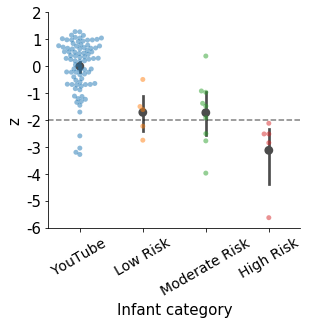

In [4]:
# bayes surprise by group

fig,ax=plt.subplots(nrows=1,ncols=1, figsize=(5,5))

sns.swarmplot(ax=ax,x="risk", y="z", data=surprise, alpha=.5, dodge=True,zorder=100)
sns.pointplot(ax=ax,x="risk", y="z", data=surprise, join=False, color=[.3,.3,.3],zorder=-1, estimator=np.mean)

ax.plot([-.5,6], [-2]*2, alpha=.5,color=[0,0,0], ls='--')
ax.set_ylabel('z', fontsize=fontsize)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['YouTube', 'Low Risk', 'Moderate Risk', 'High Risk'],fontsize=fontsize-1,rotation=30)
ax.set_yticks(np.arange(-6,3))
ax.set_yticklabels(np.arange(-6,3),fontsize=fontsize)

ax.set_xlabel('Infant category',fontsize=fontsize)
sns.despine()

fig.subplots_adjust(left=.2, bottom=.3, right=.9, top=.9, wspace=.2, hspace=.2)
fig.savefig('../data/visualization/bayes_surprise.pdf') 

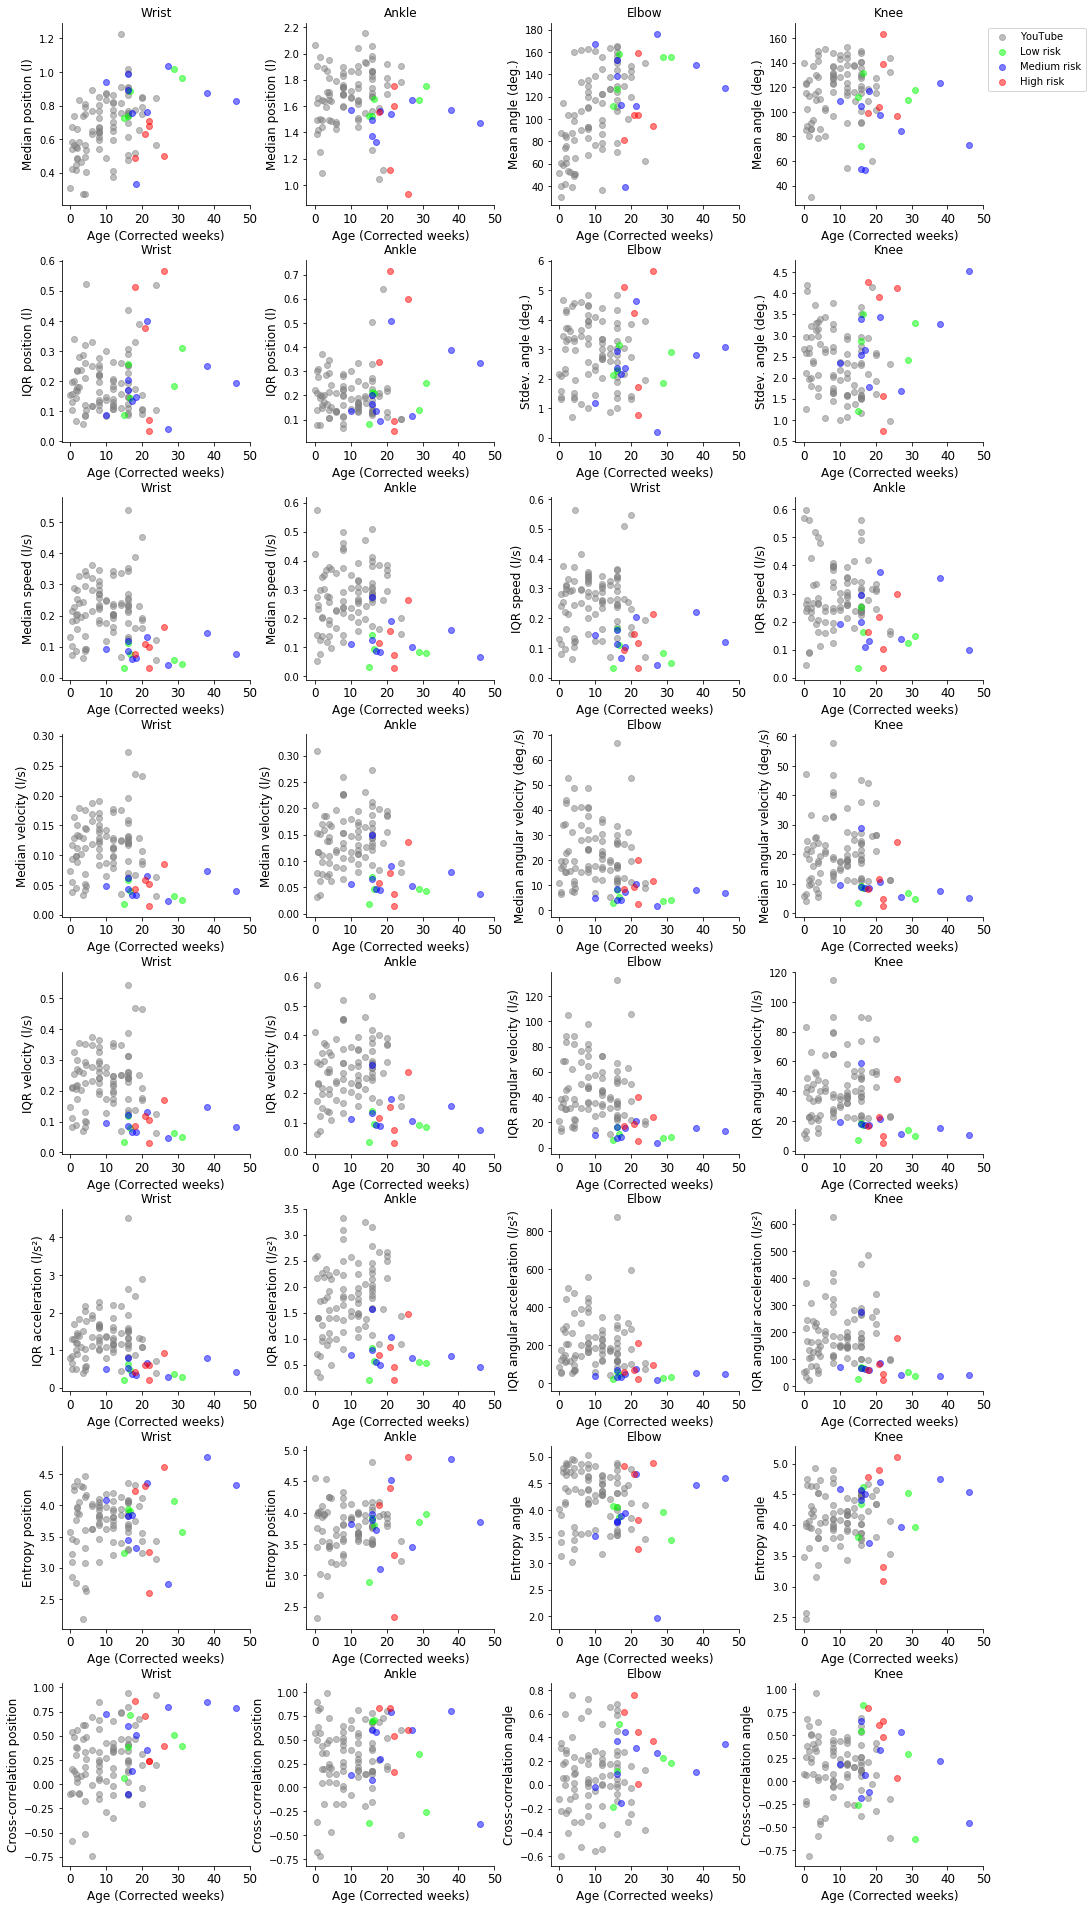

In [5]:
# plot features x age x risk
fontsize = 12
nrow = 8
ncol = 4
s = 4

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(4*s, 8*s))
for i, icol in enumerate(feature_list):
    
    ax = axs.flat[i]
#     ax.text(xlabel, ylabel, labelz[i], transform=ax.transAxes,fontsize=fontsize_label, va='top', ha='right')
    sns.regplot(data=features[(features.risk==0)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5},label='YouTube')
    sns.regplot(data=features[(features.risk==1)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5},label='Low risk')
    sns.regplot(data=features[(features.risk==2)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5},label='Medium risk')
    sns.regplot(data=features[(features.risk==3)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5},label='High risk')
    if i==3:
        ax.legend(bbox_to_anchor=(1,1))
    
    ax.set_ylabel(labels_list_feature[i],fontsize=fontsize)
    ax.set_title(labels_list_part[i],fontsize=fontsize)
    ax.set_xlabel('Age (Corrected weeks)',fontsize=fontsize)
    ax.set_xticks(np.arange(0,60,step=10))
    ax.set_xticklabels(np.arange(0,60,step=10), fontsize=fontsize)
fig.subplots_adjust(left=.1, bottom=.1, right=.9, top=.9, wspace=.3, hspace=.3) 
sns.despine()

fig.savefig('../data/visualization/features.pdf') 

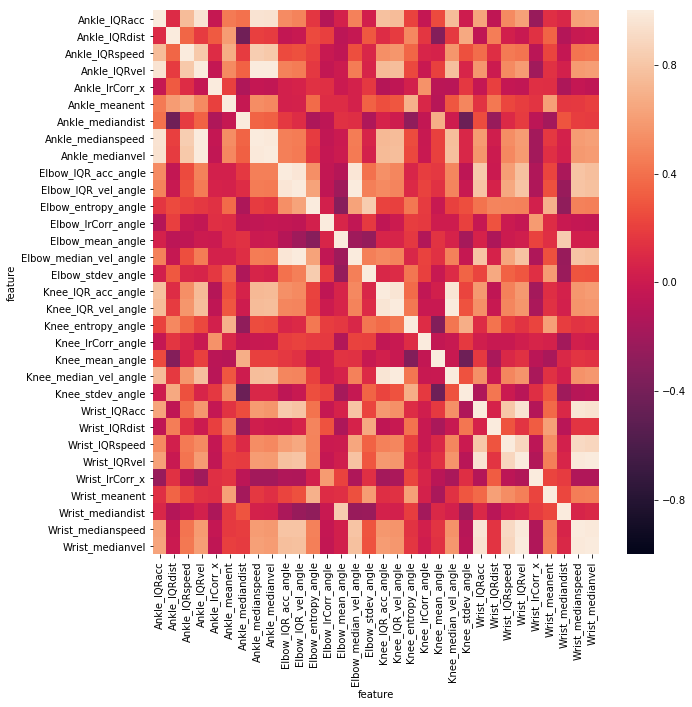

In [6]:
# plt.rc('figure', figsize=(5,5))
a = pd.pivot_table(features, index=['infant', 'risk'], columns=['feature'])['Value'].reset_index()
a = a.drop('risk', axis=1)

fig, ax = plt.subplots(ncols = 1,nrows=1, figsize=(10,10))
sns.heatmap(a.corr(), vmin=-1, vmax = 1,ax=ax)
plt.show()

In [7]:
sdf = surprise.copy(deep=True)
sdf['feature_label_2'] = 'All features'
sdf['part'] = 'All features'
list_of_models = ['Wrist', 'Elbow', 'Ankle', 'Knee']

for i,ifeature in enumerate(feature_list):

    f_plot = features[np.isin(features.feature, ifeature)]
    # normalize surprise by YT
    s = f_plot.groupby(['infant', 'risk', 'age_in_weeks', 'age_bracket', 'part', 'feature_label_2'])['minus_log_pfeature'].sum().reset_index()
    s['z'] = (s['minus_log_pfeature'] - s.loc[s.risk==0, 'minus_log_pfeature'].mean())/s.loc[s.risk==0,'minus_log_pfeature'].std()
    s['p'] =(sc.stats.norm.sf(np.abs(s['z']))*2).round(3)
    s['feature'] = ifeature#list_of_models[i]
    s['feature_label'] = f_plot.feature_label_2.unique()[0]
    sdf = sdf.append(s)
    

def auc_score(df):
    return roc_auc_score(df.label,df.prob)

sdf1 = sdf[np.isin(sdf.risk, [1,3])]

sdf1['label'] = (sdf1.risk-1)/2
sdf1['prob'] = 1-sdf1['p']

auc = sdf1.groupby('feature_label_2').apply(auc_score).reset_index()
auc.columns = ['features', 'roc_score']
auc = auc.loc[:,:].sort_values('roc_score',ascending=False).reset_index()

idx = np.where(auc.features=='All features')[0][0]
auc = pd.concat([auc.iloc[idx:idx+1,:], auc.drop(idx, axis=0)],axis=0)

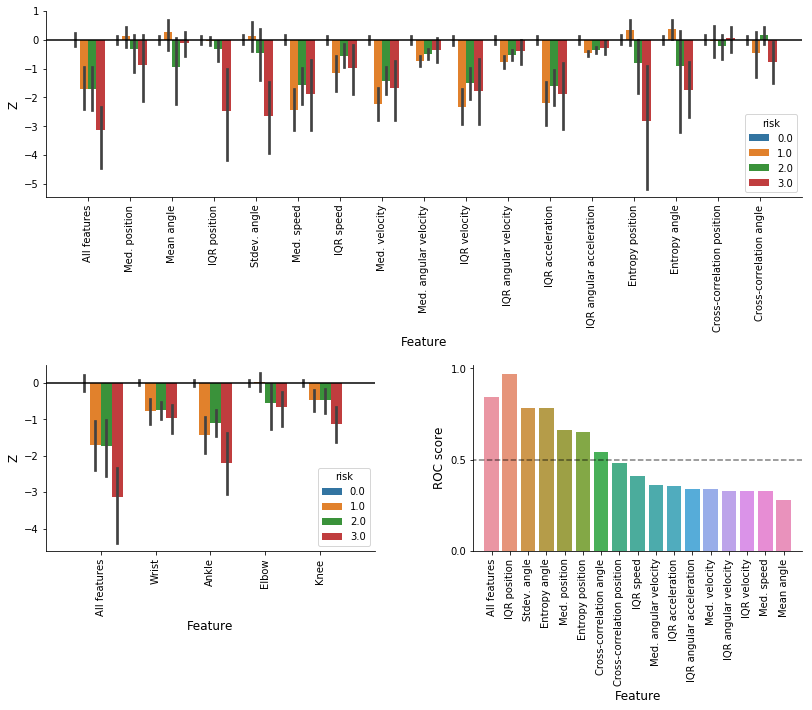

In [8]:
rotation=90
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(211) 
sns.barplot(data=sdf, y='z', x='feature_label_2', hue='risk', ax = ax)
ax.set_xticks(np.arange(len(sdf.feature_label_2.unique()))) 
ax.plot([-1,len(sdf.feature_label_2.unique())],[0,0], color=[0,0,0])
ax.set_xlim(-1,len(sdf.feature_label_2.unique()))
ax.set_xticklabels(list(sdf.feature_label_2.unique()),rotation=rotation)
ax.set_ylabel('Z', fontsize=fontsize)
ax.set_xlabel('Feature', fontsize=fontsize)

ax = fig.add_subplot(223)
sns.barplot(data=sdf, y='z', x='part', hue='risk', ax = ax)
ax.plot([-1,len(sdf.part.unique())],[0,0], color=[0,0,0])
ax.set_xlim(-1,len(sdf.part.unique()))
ax.set_xticks(np.arange(len(sdf.part.unique()))) 
ax.set_xticklabels(list(sdf.part.unique()),rotation=rotation)
ax.set_ylabel('Z', fontsize=fontsize)
ax.set_xlabel('Feature', fontsize=fontsize)

ax = fig.add_subplot(224)
sns.barplot(data=auc, x = 'features',y = 'roc_score',ax=ax)
ax.plot([-2,len(auc)+1], [.5,.5],alpha=.5, ls='--', color=[0,0,0])
ax.set_xticks(np.arange(len(auc))) 
ax.set_xticklabels(list(auc.features),rotation=rotation)
ax.set_yticks([0,.5,1])
ax.set_xlim(-1,len(auc))
ax.set_ylabel('ROC score', fontsize=fontsize)
ax.set_xlabel('Feature', fontsize=fontsize)
sns.despine()
fig.subplots_adjust(left=.2, bottom=.25, right=.9, top=1, wspace=.3, hspace=.9)

fig.savefig('../data/visualization/z_groupby_feature.pdf') 